# TCLAB System ID
## Builds on the results provided here https://github.com/jckantor/TCLab

In [18]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material
plt.rcParams.update({"axes.grid" : True})
                     
from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data

from scipy.integrate import solve_ivp, odeint
from scipy.interpolate import interp1d
from scipy.optimize import minimize

import pandas as pd

try: 
    from tclab import TCLab, clock, Historian, Plotter, setup
except:
    %pip install tclab
    from tclab import TCLab, clock, Historian, Plotter, setup

Running Python: 3.8.12


## Collect Data
only needed if collecting the data from the device

## Analyze Data

In [11]:
dataset1 = True
if dataset1:
    filename = "./data/tclab-data.csv"
else:
    filename = "./data/tclab-data_1673823210.csv"

try:
    df = pd.read_csv(filename)
except:
    if dataset1:
        !wget -O ./data/tclab-data.csv https://raw.githubusercontent.com/JonHowMIT/16_32_Software/main/data/tclab-data.csv
    else:
        !wget -O ./data/tclab-data_1673823210.csv https://raw.githubusercontent.com/JonHowMIT/16_32_Software/main/data/tclab-data_1673823210.csv
    df = pd.read_csv(filename)
    
t = np.array(df["Time"])
T1 = np.array(df["T1"])
T2 = np.array(df["T2"])
Q1 = np.array(df["Q1"])
Q2 = np.array(df["Q2"])
T_ambient = (T1[0]+T1[0])/2.0

In [12]:
def plot_data(t, T, T_pred, Q, title='Plots'):
    
    fig = plt.figure(figsize=(12,6))
    grid = plt.GridSpec(4, 1)
    ax = [fig.add_subplot(grid[:2]), fig.add_subplot(grid[2]), fig.add_subplot(grid[3])]

    ax[0].plot(t, T, t, T_pred)
    ax[0].set_ylabel("deg C")
    ax[0].legend(["T", "T_pred"])
    ax[0].set_xlim([min(t),max(t)])
    ax[0].set_ylim([0,80])
    ax[0].set_title(title+filename)
    
    ax[1].plot(t, T_pred - T)
    ax[1].set_ylabel("deg C")
    ax[1].legend(["Error"])
    ax[1].set_xlim([min(t),max(t)])
    ax[1].set_ylim([-10,10])
    
    ax[2].plot(t, Q)
    ax[2].set_ylabel("%")
    ax[2].legend(["Q"])
    ax[2].set_xlim([min(t),max(t)])
    ax[2].set_ylim([0,80])    
    
    for a in ax: nicegrid(a)
    ax[-1].set_xlabel("time / seconds")
    plt.tight_layout()
    return ax

## Two heater, four state model

\begin{align*}
C_p^H \frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{H,2} - T_{H,1}) + U_c(T_{S,1} - T_{H,1}) + P_1Q_1 \\
C_p^S \frac{dT_{S,1}}{dt} & = U_c(T_{H,1} - T_{S,1}) \\
C_p^H \frac{dT_{H,2}}{dt} & = U_a(T_{amb} - T_{H,2}) + U_b(T_{H,1} - T_{H,2}) + U_c(T_{S,2} - T_{H,2}) + P_2Q_2 \\
C_p^S \frac{dT_{S,2}}{dt} & = U_c(T_{H,2} - T_{S,2}) 
\end{align*}

In [13]:
# Crude initial guesses
# 100 here due to scaling error

P1 = 5.5/100 #4                 # watts
P2 = 2/100                 # watts
Ua = 0.044 # 0.044             # watts/deg C
Ub = 0.018             # watts/deg C
Cp = 7 # 7                 # joules/deg C

[15.7425, 13.842, 0.514, 0.08, 0.057, 0.02]


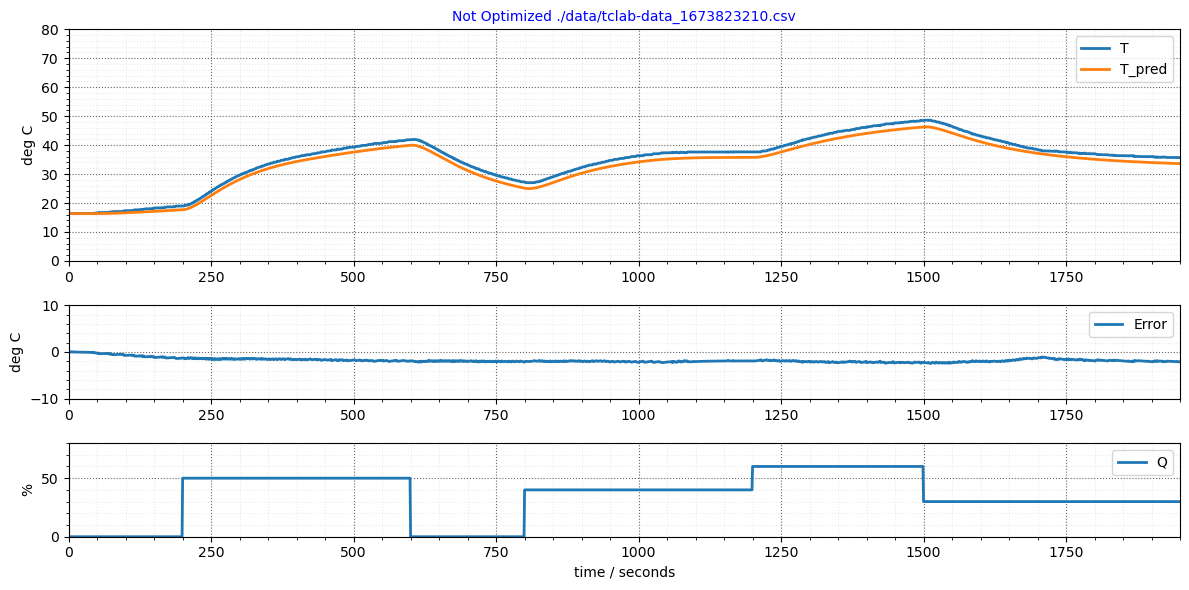

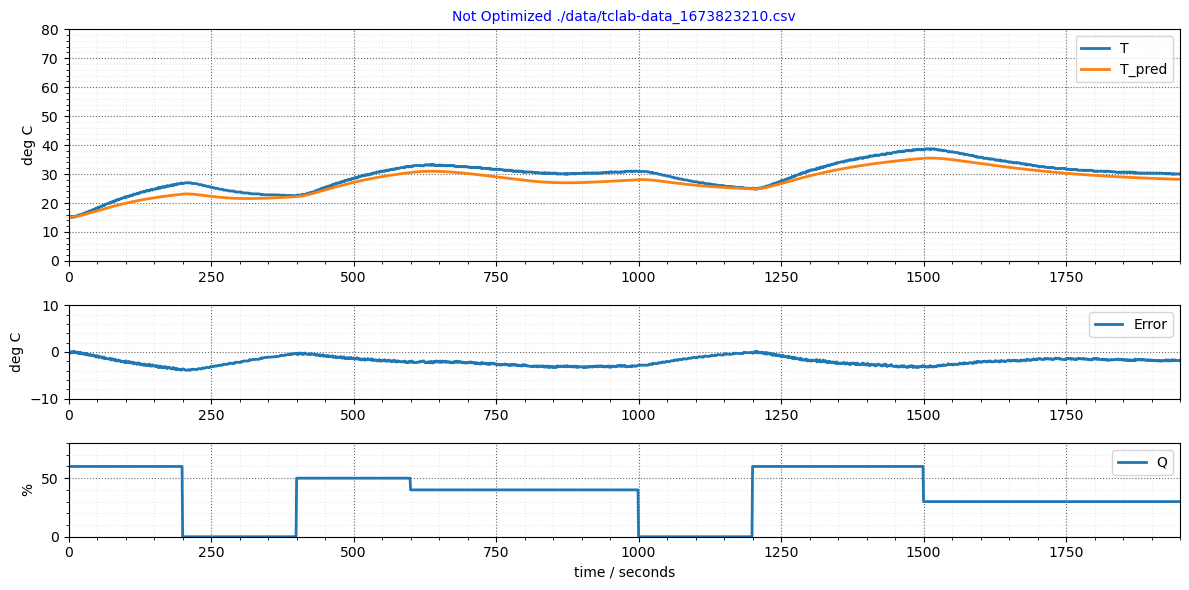

In [14]:
N_horizon = 1950

def model_complete(param, plot=False, title='Simulation Comparison', Save=False):
    # access parameter values
    T_ambient, Cp_H, Cp_S, Ua, Ub, Uc = param    
    #P1 = 0.04

    # simulation in deviation variables
    def deriv(T, ti):
        T_H1, T_S1, T_H2, T_S2 = T
        u1 = interp1d(x = t, y = Q1, kind='zero')
        u2 = interp1d(x = t, y = Q2, kind='zero')
        u1(ti)
        dT_H1 = (Ua*(T_ambient - T_H1) + Ub*(T_H2 - T_H1) + Uc*(T_S1 - T_H1) + P1*u1(ti))/Cp_H
        dT_S1 = Uc*(T_H1 - T_S1)/Cp_S
        dT_H2 = (Ua*(T_ambient - T_H2) + Ub*(T_H1 - T_H2) + Uc*(T_S2 - T_H2) + P2*u2(ti))/Cp_H
        dT_S2 = Uc*(T_H2 - T_S2)/Cp_S
        return [dT_H1, dT_S1, dT_H2, dT_S2]

    T_pred = odeint(deriv, [T1[0], T1[0], T2[0], T2[0]], t[0:N_horizon])
    T1_pred = T_pred[:,1] # sensor state
    T2_pred = T_pred[:,3]

    # comparing to experimental data
    if plot:
        print(param)
        plot_data(t[0:N_horizon], T1[0:N_horizon], T1_pred, Q1[0:N_horizon],title=title)
        if Save:
            II = int(time.time())
            plt.savefig("figs/TCLAB_ID_"+str(II)+".png")
        plot_data(t[0:N_horizon], T2[0:N_horizon], T2_pred, Q2[0:N_horizon],title=title)
        if Save:
            plt.savefig("figs/TCLAB_ID_"+str(II+1)+".png")    
    return (np.linalg.norm(T1_pred - T1[0:N_horizon]) + np.linalg.norm(T2_pred - T2[0:N_horizon]))/2

param_complete = [(T1[0]+T2[0])/2.0, Cp, Cp/5, Ua, Ua, Ua] # crude guess
param_complete = [(T1[0]+T2[0])/2.0,   13.842,    0.514,   0.080,    0.057,    0.020]
J_notopt = model_complete(param_complete, plot=True, title='Not Optimized ', Save=True)

In [15]:
# first data set [  17.674   13.842    0.514    0.080    0.057    0.020]
# second data set [ 16.890   11.125    2.321    0.076    0.058    0.077 ]

In [16]:
bounds = Bounds([15, 7, 0.5, 0, 0, 0], [30, 14, np.inf, np.inf, np.inf, np.inf]) 
results = minimize(model_complete, param_complete, method='nelder-mead', bounds=bounds)

[ 17.7698  13.4488  0.5343  0.0804  0.0564  0.0198]


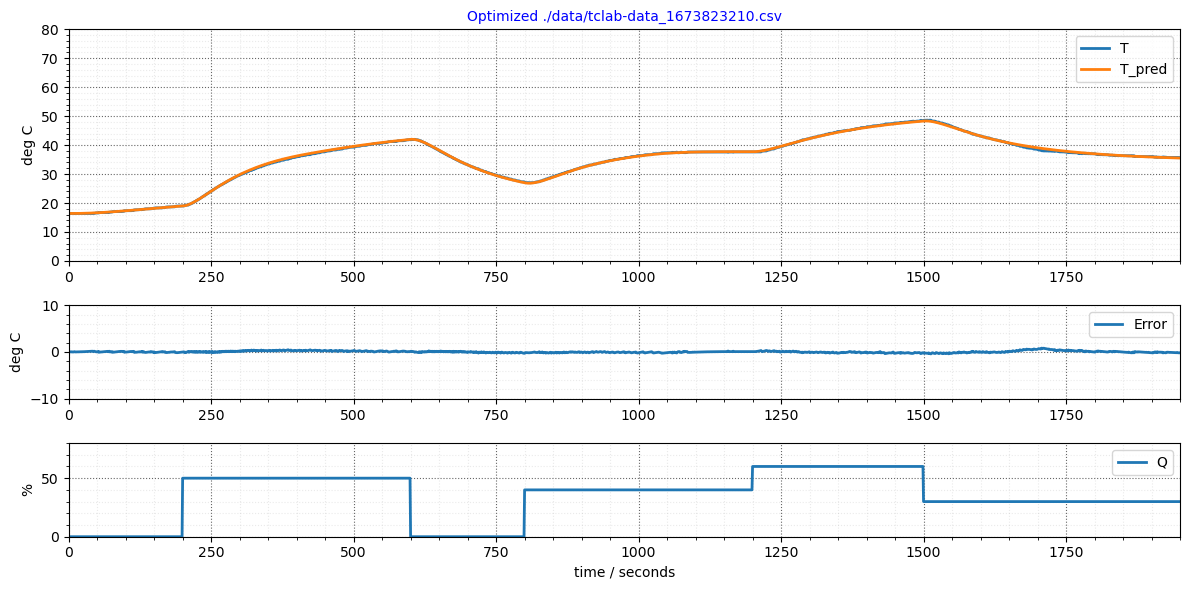

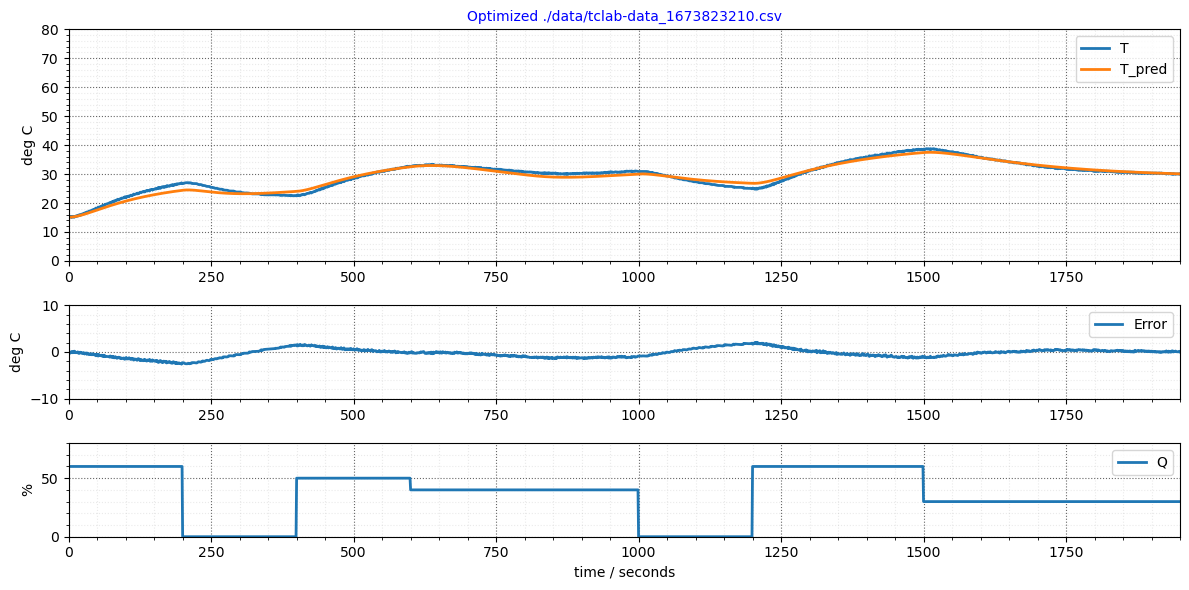

In [17]:
param_complete = results.x
J_opt = model_complete(param_complete, plot=True, title='Optimized ', Save=True)
# T_ambient, Cp_H, Cp_S, Ua, Ub, Uc